In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
from tqdm import tqdm
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/')
import psix

In [201]:
psix_single_lineage = psix.Psix()
psix_single_lineage.process_rnaseq(
        'single_lineage/processed_tables/SE_counts_0.1.tab.gz',
        'single_lineage/processed_tables/constitutive_introns_0.1.tab.gz',
        'single_lineage/processed_tables/tpm_0.1.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

psix_single_lineage.compute_psix_scores(latent='single_lineage/processed_tables/pc2_rd.tab.gz', n_jobs=25, 
                                n_random_exons=10000, n_neighbors=100)


Obtaining psi tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1000/1000 [00:00<00:00, 8271.48it/s]

Successfully processed RNA-seq data
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 3486 exons



100%|██████████| 3486/3486 [00:34<00:00, 100.39it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [41:12<00:00, 98.91s/it]   


Successfully estimated p-values


In [3]:
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests


def run_kw(exon_psi, labels):
    kw_input = []
    for l in labels:
        kw_input.append(list(exon_psi[l]))
        
    if len(labels) == 2:
        return kruskal(kw_input[0], kw_input[1], nan_policy='omit')
    if len(labels) == 3:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], nan_policy='omit')
    if len(labels) == 4:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], nan_policy='omit')
    if len(labels) == 5:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], nan_policy='omit')
    if len(labels) == 6:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], nan_policy='omit')
    if len(labels) == 7:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], kw_input[6], nan_policy='omit')
    if len(labels) == 8:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], kw_input[6], kw_input[7], nan_policy='omit')
    
def run_kw_dset(psi_table, labels, exon_list):
    kw_output = pd.DataFrame()
    kw_score = []
    pvals = []
    for exon in tqdm(exon_list, position=0, leave=True):
        score, p = run_kw(psi_table.loc[exon], labels)
        kw_score.append(score)
        pvals.append(p)
    kw_output['KW_score'] = kw_score
    kw_output['pvals'] = pvals
    kw_output['qvals'] = multipletests(pvals, method='fdr_bh')[1]
    kw_output.index = exon_list
    return kw_output

# tiklova_kw = run_kw_dset(tiklova_PSI, tiklova_labels, tiklova_psix.index)

In [4]:
meta = pd.read_csv('single_lineage/sim_output/meta.tab', sep='\t')
meta.index=['cell_'+str(i+1) for i in range(1000)]

In [88]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(8)

rd = pd.read_csv('single_lineage/processed_tables/pc2_rd.tab.gz', sep='\t', index_col=0)
labels_ac = ac.fit_predict(rd)

labels = [rd.loc[labels_ac==0].index, rd.loc[labels_ac==1].index, rd.loc[labels_ac==2].index,
          rd.loc[labels_ac==3].index, rd.loc[labels_ac==4].index, rd.loc[labels_ac==5].index,
         rd.loc[labels_ac==6].index, rd.loc[labels_ac==7].index]

In [73]:
rd.loc[labels_ac==5]

,PC_1,PC_2


In [5]:
pop_1 = meta.loc[meta['pop'] == '3_1'].index
pop_2 = meta.loc[meta['pop'] == '3_2'].index
labels = [pop_1, pop_2]

In [202]:
psix_results = psix_single_lineage.psix_results

(array([1446.,  174.,  145.,  116.,  131.,  102.,  104.,  101.,   80.,
          85.,   91.,   96.,   93.,  125.,   89.,   99.,  100.,   96.,
         106.,  107.]),
 array([4.99750125e-04, 5.04747626e-02, 1.00449775e-01, 1.50424788e-01,
        2.00399800e-01, 2.50374813e-01, 3.00349825e-01, 3.50324838e-01,
        4.00299850e-01, 4.50274863e-01, 5.00249875e-01, 5.50224888e-01,
        6.00199900e-01, 6.50174913e-01, 7.00149925e-01, 7.50124938e-01,
        8.00099950e-01, 8.50074963e-01, 9.00049975e-01, 9.50024988e-01,
        1.00000000e+00]),
 <a list of 20 Patch objects>)

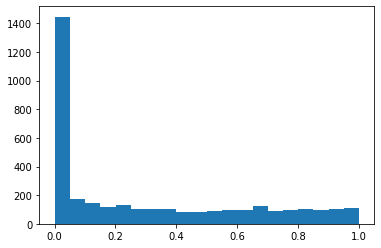

In [7]:
plt.hist(psix_single_lineage.psix_results.pvals, bins=20)#.index

In [8]:
tiklova_kw = run_kw_dset(psix_single_lineage.adata.uns['psi'][psix_single_lineage.psix_results.index].T, 
                         labels, psix_single_lineage.psix_results.index)

100%|██████████| 3486/3486 [00:26<00:00, 130.21it/s]


In [11]:
pos = pd.Index(['gene' + str(i) for i in range(1, 2501)]) & psix_results.index
neg = pd.Index(['gene' + str(i) for i in range(2501, 5001)]) & psix_results.index
labels = [1]*len(pos) + [0]*len(neg)
order = list(pos) + list(neg)

In [12]:
platonic_psi = pd.read_csv('single_lineage/sim_output/psi_platonic.tab', sep='\t', 
                           names = ['cell_'+str(i+1) for i in range(1000)])
platonic_psi.index = ['gene' + str(i+1) for i in range(5000)]

from scipy.special import logit, expit
platonic_psi = expit(platonic_psi)

In [85]:
y_ = list(((platonic_psi.max(axis=1) - platonic_psi.min(axis=1)) >= 0.01).astype(int).loc[order])

In [86]:
from sklearn.metrics import precision_recall_curve

pre, rec, thres = precision_recall_curve(y_, psix_results.loc[order].psix_score)
pre_kw, rec_kw, thres_kw = precision_recall_curve(y_, tiklova_kw.loc[order].KW_score)
pre_h, rec_h, thres_h = precision_recall_curve(y_, hs_results.loc[order].Z)

In [203]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


pre, rec, thres = precision_recall_curve(labels, psix_results.loc[order].psix_score)
pre_kw, rec_kw, thres_kw = precision_recall_curve(labels, tiklova_kw.loc[order].KW_score)
pre_h, rec_h, thres_h = precision_recall_curve(labels, hs_results.loc[order].Z)

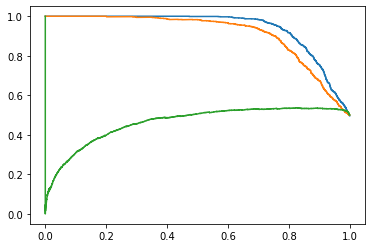

In [204]:
plt.plot(rec, pre)
plt.plot(rec_kw, pre_kw)
plt.plot(rec_h, pre_h)

In [89]:
precision_score(y_, hs_results.FDR <= 0.05)

0.5024687772291606

In [94]:
recall_score(y_, tiklova_kw.loc[order].qvals <= 0.05)

0.7630057803468208

In [95]:
recall_score(y_, psix_results.qvals <= 0.05)

0.738728323699422

In [199]:
import hotspot
rd = pd.read_csv('single_lineage/processed_tables/pc2_rd.tab.gz', sep='\t', index_col=0)

psi_table = psix_single_lineage.adata.uns['psi'][psix_single_lineage.psix_results.index].T
psi_tab_imputed = psi_table.T.fillna(psi_table.T.mean(axis=0)).T
hs = hotspot.Hotspot(psi_tab_imputed, model='none', latent=rd, umi_counts=np.ones(len(psi_table.columns)))
hs.create_knn_graph(weighted_graph=False, n_neighbors=100)
hs_results = hs.compute_autocorrelations()

100%|██████████| 3486/3486 [00:00<00:00, 5487.77it/s]


In [43]:
psi_tab_imputed

,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,cell_9,cell_10,...,cell_991,cell_992,cell_993,cell_994,cell_995,cell_996,cell_997,cell_998,cell_999,cell_1000
gene1128,1.000000,0.200000,1.000000,1.000000,0.529412,0.846154,1.000000,1.000000,0.000000,0.764706,...,0.538129,0.000000,0.538129,0.000000,0.000000,0.000000,0.538129,0.272727,0.538129,0.000000
gene1880,0.128205,0.000000,0.176471,0.000000,0.333333,0.414634,0.000000,0.381428,0.381428,0.111111,...,1.000000,1.000000,0.606061,0.381428,0.600000,1.000000,1.000000,1.000000,0.600000,1.000000
gene2332,0.500000,1.000000,0.750000,0.846154,0.714286,0.531915,0.625000,0.733333,1.000000,0.529412,...,1.000000,1.000000,0.818182,1.000000,1.000000,1.000000,1.000000,1.000000,0.769231,0.846154
gene705,0.534922,0.534922,0.000000,0.534922,0.534922,0.000000,0.000000,0.534922,0.534922,0.534922,...,0.534922,0.534922,1.000000,1.000000,1.000000,1.000000,0.629630,0.534922,0.534922,1.000000
gene1878,0.000000,0.000000,0.000000,0.000000,0.250000,0.015873,0.125000,0.166667,0.333333,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.750000,1.000000,0.349769,0.250000,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene4900,1.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.103153,0.103153,0.103153,0.000000,...,0.000000,0.103153,0.103153,0.103153,0.103153,0.000000,0.103153,0.103153,0.000000,0.103153
gene3637,0.483050,0.483050,0.483050,0.483050,0.483050,0.483050,0.483050,0.483050,0.483050,0.483050,...,0.483050,0.483050,1.000000,0.483050,0.483050,0.483050,0.483050,0.483050,0.483050,0.000000
gene3293,0.300331,0.300331,1.000000,0.300331,0.300331,1.000000,0.300331,0.300331,0.300331,1.000000,...,1.000000,0.300331,0.300331,0.300331,0.300331,0.300331,0.000000,0.300331,0.300331,0.300331
gene2372,0.327466,0.327466,0.090909,0.000000,0.327466,0.327466,0.000000,0.327466,0.327466,0.327466,...,0.327466,0.200000,0.327466,0.000000,0.327466,0.327466,0.000000,0.327466,0.327466,0.327466


In [29]:
psi_tab_imputed = psi_table.T.fillna(psi_table.T.mean(axis=0)).T

In [39]:
psi_tab_imputed

,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,cell_9,cell_10,...,cell_991,cell_992,cell_993,cell_994,cell_995,cell_996,cell_997,cell_998,cell_999,cell_1000
gene1128,1.000000,0.200000,1.000000,1.000000,0.529412,0.846154,1.00000,1.000000,0.000000,0.764706,...,0.56129,0.000000,0.551298,0.000000,0.000000,0.000000,0.544963,0.272727,0.563838,0.000000
gene1880,0.128205,0.000000,0.176471,0.000000,0.333333,0.414634,0.00000,0.558837,0.569369,0.111111,...,1.00000,1.000000,0.606061,0.547775,0.600000,1.000000,1.000000,1.000000,0.600000,1.000000
gene2332,0.500000,1.000000,0.750000,0.846154,0.714286,0.531915,0.62500,0.733333,1.000000,0.529412,...,1.00000,1.000000,0.818182,1.000000,1.000000,1.000000,1.000000,1.000000,0.769231,0.846154
gene705,0.580330,0.567572,0.000000,0.580164,0.559434,0.000000,0.00000,0.558837,0.569369,0.563204,...,0.56129,0.558171,1.000000,1.000000,1.000000,1.000000,0.629630,0.561325,0.563838,1.000000
gene1878,0.000000,0.000000,0.000000,0.000000,0.250000,0.015873,0.12500,0.166667,0.333333,0.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,0.750000,1.000000,0.561325,0.250000,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene4900,1.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.58382,0.558837,0.569369,0.000000,...,0.00000,0.558171,0.551298,0.547775,0.564819,0.000000,0.544963,0.561325,0.000000,0.565714
gene3637,0.580330,0.567572,0.566302,0.580164,0.559434,0.563984,0.58382,0.558837,0.569369,0.563204,...,0.56129,0.558171,1.000000,0.547775,0.564819,0.575388,0.544963,0.561325,0.563838,0.000000
gene3293,0.580330,0.567572,1.000000,0.580164,0.559434,1.000000,0.58382,0.558837,0.569369,1.000000,...,1.00000,0.558171,0.551298,0.547775,0.564819,0.575388,0.000000,0.561325,0.563838,0.565714
gene2372,0.580330,0.567572,0.090909,0.000000,0.559434,0.563984,0.00000,0.558837,0.569369,0.563204,...,0.56129,0.200000,0.551298,0.000000,0.564819,0.575388,0.000000,0.561325,0.563838,0.565714


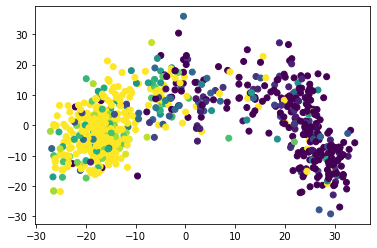

In [97]:
plt.scatter(rd.PC_1, rd.PC_2, c=psi_table.loc['gene1128'])

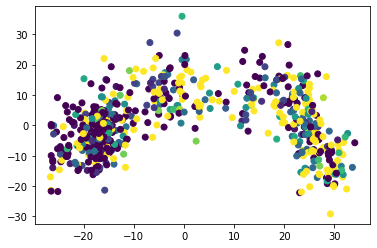

In [106]:
plt.scatter(rd.PC_1, rd.PC_2, c=psi_table.loc['gene1426'])

In [100]:
platonic_psi.loc['gene1128'].max() - platonic_psi.loc['gene1128'].min()

0.8300561863800547

In [107]:
platonic_psi.loc['gene1426'].max() - platonic_psi.loc['gene1426'].min()

0.312481289703649

In [115]:
psix_results.loc[(psix_results.qvals>= 0.2)].index & tiklova_kw.loc[(tiklova_kw.qvals<= 0.001)].index 

Index(['gene2378', 'gene1545', 'gene202', 'gene3991', 'gene2879', 'gene1423',
       'gene1045', 'gene1458', 'gene2049', 'gene332', 'gene1329', 'gene4233',
       'gene4605', 'gene2747', 'gene3515', 'gene220', 'gene3034', 'gene4529',
       'gene2741', 'gene1608', 'gene1947', 'gene825', 'gene583', 'gene3172',
       'gene4590', 'gene3011', 'gene1667', 'gene751', 'gene3794', 'gene926',
       'gene2764', 'gene2196', 'gene3489', 'gene4062', 'gene460', 'gene3275',
       'gene4136', 'gene4189', 'gene57', 'gene2763', 'gene1459', 'gene1505',
       'gene3221', 'gene3112', 'gene4322', 'gene4988', 'gene4933', 'gene2505',
       'gene959', 'gene3959', 'gene2709', 'gene4005', 'gene3737', 'gene2975',
       'gene3284', 'gene2958', 'gene3229', 'gene4342', 'gene2563', 'gene3116',
       'gene4452', 'gene3062'],
      dtype='object')

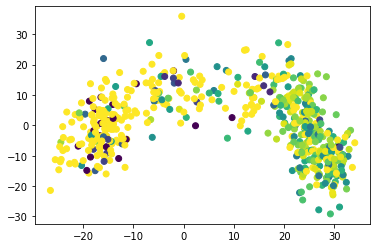

In [119]:
plt.scatter(rd.PC_1, rd.PC_2, c=psi_table.loc['gene4452'])

In [223]:
psix_results.loc['gene2505']

psix_score   -0.017740
pvals         0.720928
qvals         0.854642
Name: gene2505, dtype: float64

In [224]:
tiklova_kw.loc['gene2505']

KW_score    21.527603
pvals        0.000003
qvals        0.000014
Name: gene2505, dtype: float64

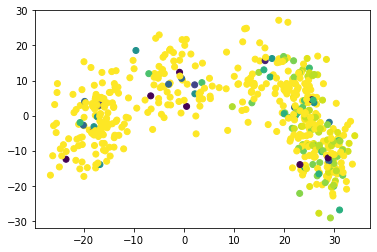

In [225]:
plt.scatter(rd.PC_1, rd.PC_2, c=psi_table.loc['gene2505'])

In [222]:
tiklova_kw.loc[neg].loc[tiklova_kw.loc[neg].qvals <= 0.01]

,KW_score,pvals,qvals
gene2505,21.527603,0.000003,0.000014
gene2533,8.666785,0.003241,0.009016
gene2563,13.292369,0.000266,0.000859
gene2709,20.083463,0.000007,0.000028
gene2741,16.848423,0.000040,0.000144
...,...,...,...
gene4671,10.024418,0.001545,0.004488
gene4711,11.422341,0.000726,0.002219
gene4745,10.706572,0.001068,0.003189
gene4933,20.152511,0.000007,0.000027


In [161]:
from scipy.stats import probplot
from scipy import stats

In [205]:
psix_probplot = probplot(-np.log10(psix_results.loc[neg].pvals), dist='norm')

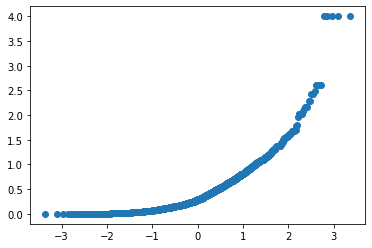

In [206]:
plt.scatter(psix_probplot[0][0], psix_probplot[0][1])

(0.0, 5.0)

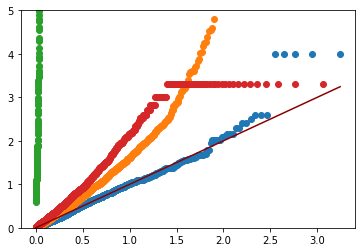

In [207]:
plt.scatter(sorted(-np.log10(np.arange(0+(1/len(neg)), 1+(1/len(neg)), step = 1/len(neg)))),
            sorted(-np.log10(psix_results.loc[neg].pvals)))

plt.scatter(sorted(-np.log10(np.arange(0+(1/len(neg)), 1+(1/len(neg)), step = 1/len(neg)))),
            sorted(-np.log10(tiklova_kw.loc[neg].pvals)))

plt.scatter(sorted(-np.log10(np.arange(0+(1/len(neg)), 1+(1/len(neg)), step = 1/len(neg)))),
            sorted(-np.log10(hs_results.loc[neg].Pval)))


plt.scatter(sorted(-np.log10(np.arange(0+(1/1149), 1+(1/1149), step = 1/1149))),
            sorted(-np.log10(gearyc.loc[gearyc.loc[gearyc.C_score > 0].index & pd.Index(neg)].pvals)))

plt.plot(sorted(-np.log10(np.arange(0+(1/len(neg)), 1+(1/len(neg)), step = 1/len(neg)))),
            sorted(-np.log10(np.arange(0+(1/len(neg)), 1+(1/len(neg)), step = 1/len(neg)))), c='darkred')

plt.ylim((0, 5))

In [191]:
gearyc.loc[gearyc.loc[gearyc.C_score > 0].index & pd.Index(neg)]

,C_score,pvals
gene2505,0.030616,0.321339
gene2510,0.031922,0.014993
gene2513,0.031868,0.350825
gene2515,0.033919,0.412794
gene2516,0.017164,0.128436
...,...,...
gene4993,0.085988,0.004498
gene4994,0.012187,0.254373
gene4997,0.019676,0.032484
gene4998,0.011024,0.307846


(array([252.,  84.,  79.,  68.,  48.,  52.,  56.,  44.,  45.,  47.,  51.,
         36.,  41.,  37.,  46.,  45.,  26.,  31.,  37., 631.]),
 array([4.99750125e-04, 5.04747626e-02, 1.00449775e-01, 1.50424788e-01,
        2.00399800e-01, 2.50374813e-01, 3.00349825e-01, 3.50324838e-01,
        4.00299850e-01, 4.50274863e-01, 5.00249875e-01, 5.50224888e-01,
        6.00199900e-01, 6.50174913e-01, 7.00149925e-01, 7.50124938e-01,
        8.00099950e-01, 8.50074963e-01, 9.00049975e-01, 9.50024988e-01,
        1.00000000e+00]),
 <a list of 20 Patch objects>)

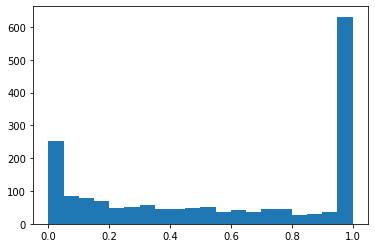

In [129]:
plt.hist(gearyc.loc[neg].pvals, bins=20)

(array([259., 120., 106.,  84.,  86.,  75.,  95.,  85.,  87.,  70.,  69.,
         60.,  64.,  83.,  65.,  76.,  55.,  69.,  65.,  83.]),
 array([1.65358777e-18, 4.99674433e-02, 9.99348865e-02, 1.49902330e-01,
        1.99869773e-01, 2.49837216e-01, 2.99804660e-01, 3.49772103e-01,
        3.99739546e-01, 4.49706989e-01, 4.99674433e-01, 5.49641876e-01,
        5.99609319e-01, 6.49576762e-01, 6.99544206e-01, 7.49511649e-01,
        7.99479092e-01, 8.49446535e-01, 8.99413979e-01, 9.49381422e-01,
        9.99348865e-01]),
 <a list of 20 Patch objects>)

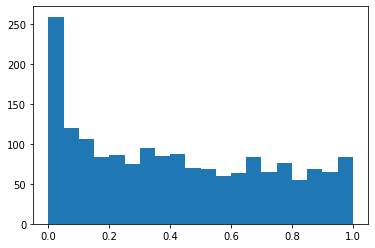

In [123]:
plt.hist(tiklova_kw.loc[neg].pvals, bins=20)

In [126]:
psix_single_lineage.adata.uns['psi'].T.to_csv('single_lineage/processed_tables/psi.tab.gz', 
                                              sep='\t', index=True, header=True)

In [193]:
gearyc = pd.read_csv('single_lineage/gearyc_output.tab.gz', sep='\t', index_col=0)

In [194]:
gearyc

,C_score,pvals
gene1,0.158189,0.000500
gene3,0.028023,0.011494
gene4,0.333843,0.000500
gene5,0.063359,0.001000
gene7,0.399201,0.000500
...,...,...
gene4994,0.012187,0.254373
gene4996,-0.003716,1.000000
gene4997,0.019676,0.032484
gene4998,0.011024,0.307846


In [106]:
from sklearn.metrics import precision_recall_curve

pre, rec, thres = precision_recall_curve(labels, psix_results.loc[order].psix_score)
pre_kw, rec_kw, thres_kw = precision_recall_curve(labels, tiklova_kw.loc[order].KW_score)
pre_c, rec_c, thres_c = precision_recall_curve(labels, gearyc.loc[order].C_score)

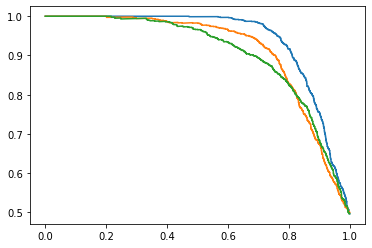

In [107]:
plt.plot(rec, pre)
plt.plot(rec_kw, pre_kw)
plt.plot(rec_c, pre_c)

In [220]:
psix_three_lineage = psix.Psix()
psix_three_lineage.process_rnaseq(
        'three_lineages/processed_tables/SE_counts_0.1.tab.gz',
        'three_lineages/processed_tables/constitutive_introns_0.1.tab.gz',
        'three_lineages/processed_tables/tpm_0.1.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

psix_three_lineage.compute_psix_scores(latent='three_lineages/processed_tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=2000, n_neighbors=200)


Obtaining psi tables...
Reading TPM and transforming to mRNA counts...


 17%|█▋        | 349/2000 [00:00<00:00, 3489.95it/s]

Successfully processed RNA-seq data
cell-cell metric not found. Computing metric...


100%|██████████| 2000/2000 [00:00<00:00, 3447.00it/s]

Successfully computed cell-cell metric
Computing Psix score in 3316 exons



100%|██████████| 3316/3316 [01:00<00:00, 54.77it/s]   


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [16:42<00:00, 40.10s/it]   


Successfully estimated p-values


In [110]:
psix_three_lineage.adata.uns['psi'].T.to_csv('three_lineages/processed_tables/psi.tab.gz', 
                                              sep='\t', index=True, header=True)

In [115]:
meta = pd.read_csv('three_lineages/sim_output/meta.tab', sep='\t')
meta.index=['cell_'+str(i+1) for i in range(2000)]

pop_1 = meta.loc[meta['pop'] == '4_1'].index
pop_2 = meta.loc[meta['pop'] == '4_5'].index
pop_3 = meta.loc[meta['pop'] == '5_2'].index
pop_4 = meta.loc[meta['pop'] == '5_3'].index
labels = [pop_1, pop_2, pop_3, pop_4]

three_kw = run_kw_dset(psix_three_lineage.adata.uns['psi'][psix_three_lineage.psix_results.index].T, 
                         labels, psix_three_lineage.psix_results.index)

100%|██████████| 3316/3316 [00:43<00:00, 77.05it/s] 


In [126]:
l1 = []
with open('three_lineages/sim_output/l1_diff.txt', 'r') as l1_file:
    for i in l1_file:
        l1.append(int(i.rstrip()))
        
l2 = []
with open('three_lineages/sim_output/l2_diff.txt', 'r') as l2_file:
    for i in l2_file:
        l2.append(int(i.rstrip()))
        
l3 = []
with open('three_lineages/sim_output/l3_diff.txt', 'r') as l3_file:
    for i in l3_file:
        l3.append(int(i.rstrip()))
        
l1 = np.array(l1)
l2 = np.array(l2)
l3 = np.array(l3)

ds = ((l1 + l2 + l3)>0).astype(int)

gearyc_3l = pd.read_csv('three_lineages/gearyc_output.tab.gz', sep='\t', index_col=0)

In [221]:
psix_results = psix_three_lineage.psix_results

In [234]:
y = []
order = []
for i in range(5000):
    if ('gene'+str(i+1)) in psix_results.index:
        
        if (platonic_psi.loc['gene'+str(i+1)].max() - platonic_psi.loc['gene'+str(i+1)].min()) >= 0.1:
            y.append(1)   
        else:
            y.append(0)
#         y.append(int(ds[i]))
        order.append('gene'+str(i+1))

In [235]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

pre, rec, thres = precision_recall_curve(y, psix_results.loc[order].psix_score)
pre_kw, rec_kw, thres_kw = precision_recall_curve(y, three_kw.loc[order].KW_score)
pre_c, rec_c, thres_c = precision_recall_curve(y, gearyc_3l.loc[order].C_score)

In [236]:
print(auc(rec, pre))
print(auc(rec_kw, pre_kw))
print(auc(rec_c, pre_c))

0.9807142187658805
0.9696686810932461
0.9576338247320152


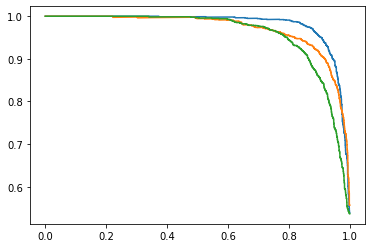

In [237]:
plt.plot(rec, pre)
plt.plot(rec_kw, pre_kw)
plt.plot(rec_c, pre_c)

In [139]:
platonic_psi = pd.read_csv('three_lineages/sim_output/psi_platonic.tab', sep='\t', 
                           names = ['cell_'+str(i+1) for i in range(2000)])
platonic_psi.index = ['gene' + str(i+1) for i in range(5000)]

In [145]:
from scipy.special import expit, logit
platonic_psi = expit(platonic_psi.loc[order])

In [149]:
(platonic_psi.max(axis=1) - platonic_psi.min(axis=1)) >= 0.2

gene1       False
gene2        True
gene3       False
gene4       False
gene7        True
            ...  
gene4995     True
gene4996    False
gene4997    False
gene4998    False
gene5000     True
Length: 3316, dtype: bool